In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import geopandas as gpd
import contextily as cx
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

# load and process FAF data

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')


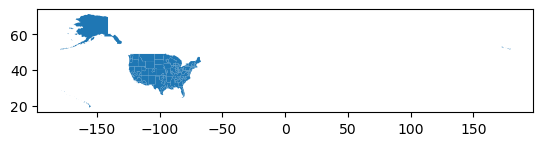

In [2]:
# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2017
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)
region_code = [531, 532, 539, 411] 
faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')
print(faf_data.columns)
faf_zone_file = 'RawData/FAF5Zones.geojson'
faf_zone = gpd.read_file(faf_zone_file)
faf_zone.plot()

crosswalk_file = 'SynthFirm_parameters/international_trade_zone_lookup.csv'
international_zonal_crosswalk = read_csv(crosswalk_file)

In [3]:
# checking FAF data
col_to_keep = ['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
               'value_2017', 'tmiles_2017']
faf_data = faf_data[col_to_keep]
faf_val_by_trade_type = \
faf_data.groupby('trade_type')[['tons_2017', 'value_2017', 'tmiles_2017']].sum()
print(faf_val_by_trade_type)

faf_data = faf_data.loc[faf_data['trade_type'] != 1]

               tons_2017    value_2017   tmiles_2017
trade_type                                          
1           1.747758e+07  1.508175e+07  4.334811e+06
2           1.193337e+06  2.270006e+06  5.502540e+05
3           1.137920e+06  1.555032e+06  5.428024e+05


In [9]:
# check value to canada
canada_import = faf_data.loc[faf_data['trade_type'] == 2]
canada_import = \
canada_import.loc[canada_import['fr_orig'] == 801]
print(canada_import[['tons_2017', 'value_2017']].sum())

canada_export = faf_data.loc[faf_data['trade_type'] == 3]
canada_export = \
canada_export.loc[canada_export['fr_dest'] == 801]
print(canada_export[['tons_2017', 'value_2017']].sum())

# seems reasonable compare to BTS values: 
# https://www.bts.gov/content/value-us-land-exports-and-imports-canada-and-mexico-mode


tons_2017     438821.905445
value_2017    331565.851430
dtype: float64
tons_2017     197855.810142
value_2017    328470.310420
dtype: float64


In [10]:
# define import export in the region

faf_crosswalk = \
international_zonal_crosswalk[['FAFID',	'CFS_CODE','CFS_NAME']]

faf_crosswalk = faf_crosswalk.drop_duplicates()
print(faf_crosswalk['CFS_NAME'].unique())
      
regional_import = faf_data.loc[faf_data['trade_type'] == 2]
regional_import = \
regional_import.loc[regional_import['dms_orig'].isin(region_code)]

regional_import['fr_orig'] = regional_import['fr_orig'].astype(int)

faf_crosswalk['FAFID'] = faf_crosswalk['FAFID'].astype(int)

regional_import = pd.merge(regional_import, faf_crosswalk,
                           left_on = 'fr_orig', 
                           right_on = 'FAFID', how = 'left')
regional_import = regional_import.drop(columns = 'FAFID')
print('total import within selected region:')
print(regional_import[['tons_2017', 'value_2017', 'tmiles_2017']].sum())

regional_export = faf_data.loc[faf_data['trade_type'] == 3]
regional_export = \
regional_export.loc[regional_export['dms_dest'].isin(region_code)]

regional_export['dms_dest'] = regional_export['dms_dest'].astype(int)

regional_export = pd.merge(regional_export, faf_crosswalk,
                           left_on = 'fr_dest', 
                           right_on = 'FAFID', how = 'left')
regional_export = regional_export.drop(columns = 'FAFID')
print('total export within selected region:')
print(regional_export[['tons_2017', 'value_2017', 'tmiles_2017']].sum())

regional_export.head(5)

['Europe & Africa' 'Asia & Oceania' 'Canada' 'Mexico'
 'Rest of the Americas']
total import within selected region:
tons_2017      53869.844511
value_2017     82099.059875
tmiles_2017    23661.159105
dtype: float64
total export within selected region:
tons_2017      88940.788921
value_2017     96268.623201
tmiles_2017    38101.999544
dtype: float64


,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,value_2017,tmiles_2017,CFS_CODE,CFS_NAME
0,NaN,11,531,801.0,NaN,4,4.0,1,3,8,0.000198,0.001370,0.000414,C,Canada
1,NaN,19,531,801.0,NaN,4,4.0,1,3,8,0.000282,0.001656,0.000589,C,Canada
2,NaN,20,539,801.0,NaN,1,1.0,1,3,7,0.000000,0.000000,0.000000,C,Canada
3,NaN,20,539,801.0,NaN,5,1.0,1,3,8,0.059241,0.088909,0.124231,C,Canada
4,NaN,41,539,801.0,NaN,1,1.0,1,3,6,0.034558,0.051866,0.048217,C,Canada


(10.0, 4500.0)

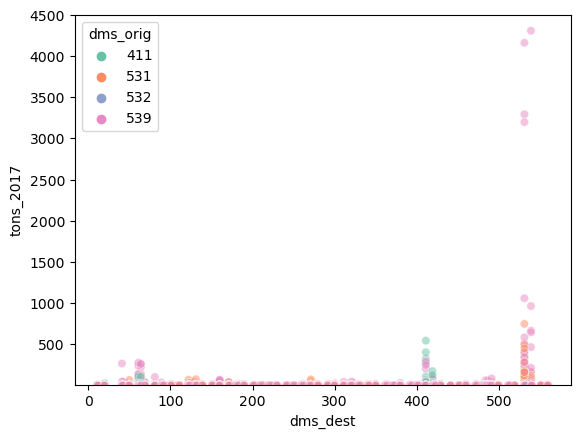

In [5]:
# check diversity
sns.scatterplot(data = regional_import, x = 'dms_dest', 
                y= 'tons_2017',hue = 'dms_orig', alpha = 0.5,
               palette = 'Set2')
plt.ylim([10, 4500])

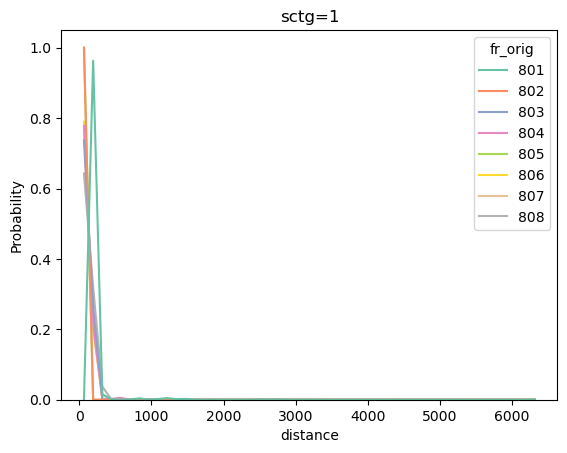

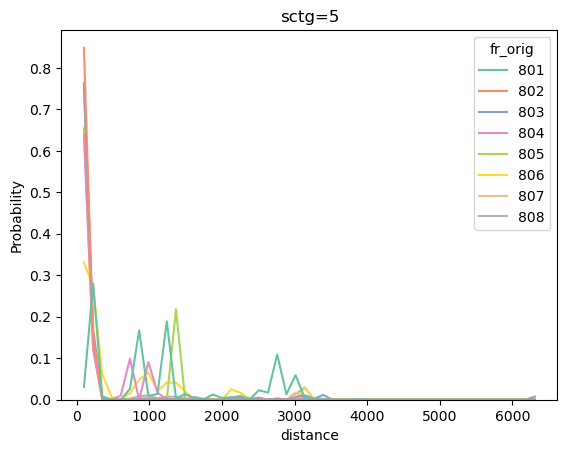

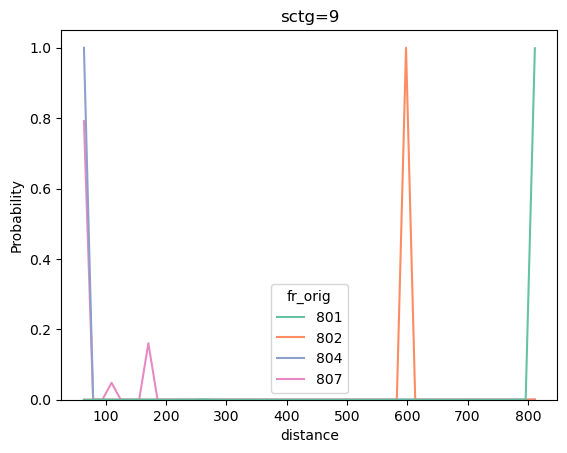

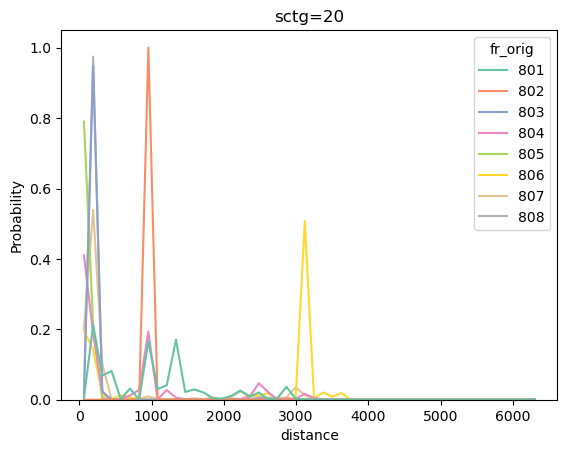

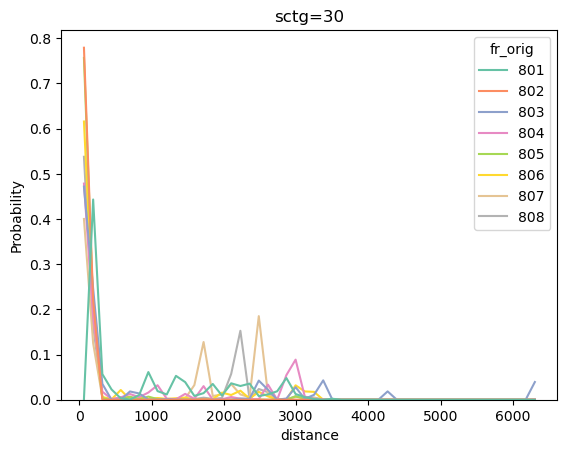

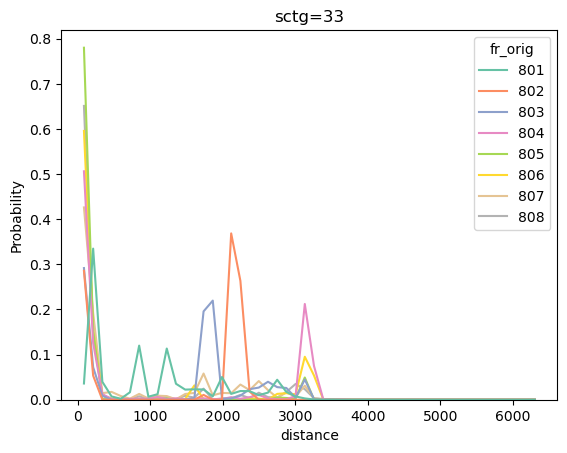

In [6]:
# check if same commodity from different countries goes to same destination
regional_import.loc[:, 'distance'] = \
1000 * regional_import.loc[:, 'tmiles_2017'] / regional_import.loc[:, 'tons_2017']
selected_sctg = [1, 5, 9, 20, 30, 33]

for sctg in selected_sctg:
    region_import_plot = \
    regional_import.loc[regional_import['sctg2'] == sctg]
    sns.histplot(data=region_import_plot, bins= 50,
                 x="distance", weights = 'tons_2017', hue="fr_orig",
                stat = 'probability', common_norm = False, 
                 element = 'poly', fill = False, palette = 'Set2')
    plt.title('sctg=' + str(sctg))
    plt.show()

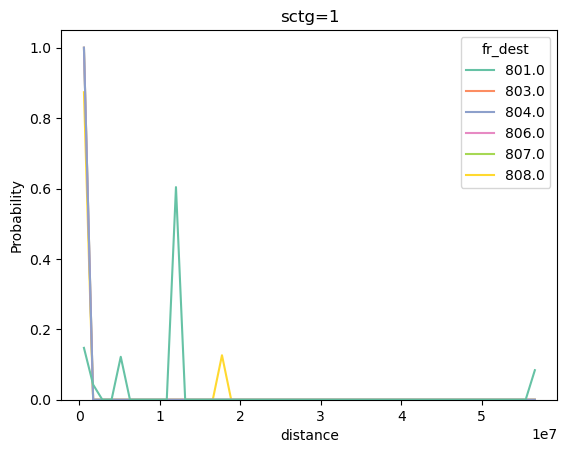

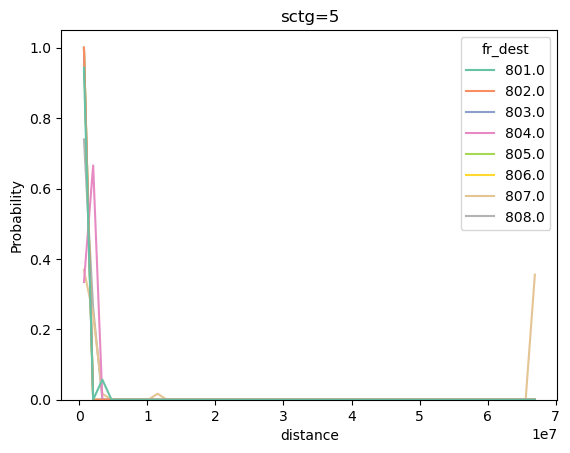

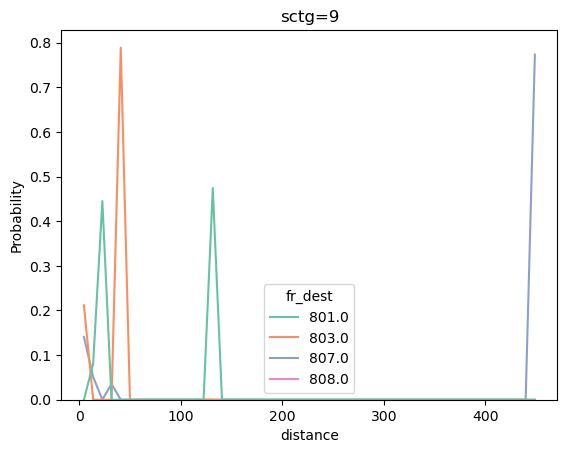

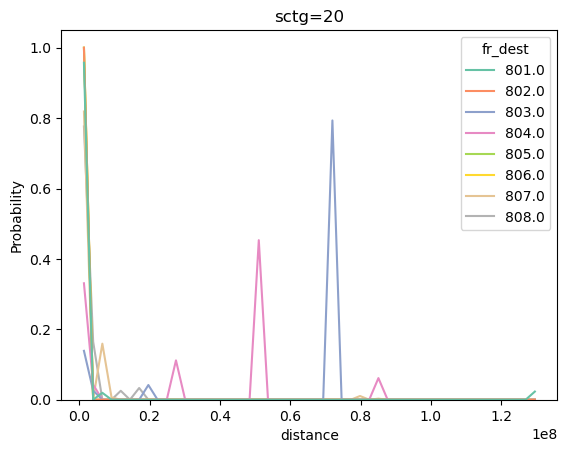

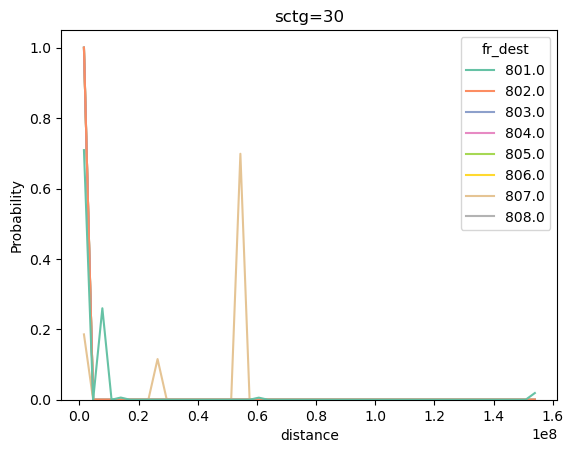

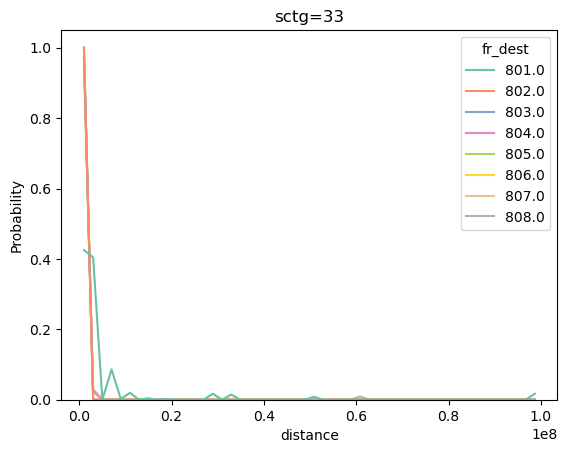

In [7]:
# check if same commodity from different countries goes to same destination
regional_export.loc[:, 'distance'] = \
1000 * regional_export.loc[:, 'tmiles_2017'] / regional_import.loc[:, 'tons_2017']
selected_sctg = [1, 5, 9, 20, 30, 33]

for sctg in selected_sctg:
    regional_export_plot = \
    regional_export.loc[regional_export['sctg2'] == sctg]
    sns.histplot(data=regional_export_plot, bins= 50,
                 x="distance", weights = 'tons_2017', hue="fr_dest",
                stat = 'probability', common_norm = False, 
                 element = 'poly', fill = False, palette = 'Set2')
    plt.title('sctg=' + str(sctg))
    plt.show()

# load and process USATO data

In [11]:
# load USATO data
port_file = 'RawData/Port/port_code_cbp.csv'
list_of_ports = read_csv(port_file)

port_loc_file = 'SynthFirm_parameters/port_location_CA_WA_OR.geojson'
port_locations = gpd.read_file(port_loc_file)

import_flow_file = 'RawData/Port/Flow/SF and Seattle Port-level Imports (2017)_with OR.csv'
regional_import_flow = read_csv(import_flow_file)

export_flow_file = 'RawData/Port/Flow/SF and Seattle Port-level Exports (2017)_with OR.csv'
regional_export_flow = read_csv(export_flow_file)

commodity_crosswalk_file = 'SynthFirm_parameters/hs_to_sctg.csv'
sctg_crosswalk = read_csv(commodity_crosswalk_file)
regional_export_flow.head(5)

,Port,Commodity,Country,Time,Total Exports Value ($US)
0,"Columbia-Snake, OR (District)",01 Live Animals,Asia,2017,4833805.0
1,"Columbia-Snake, OR (District)",01 Live Animals,Canada,2017,11146.0
2,"Columbia-Snake, OR (District)",02 Meat And Edible Meat Offal,Asia,2017,140508.0
3,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Asia,2017,237953.0
4,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Australia and Oceania,2017,85089.0


In [12]:
print(len(port_locations))

# print(list_of_ports.columns)
# port_locations.head(5)
list_of_ports.loc[:, 'PORTID'] = \
list_of_ports.loc[:, 'CBP Port Location'].str.split('(').str[0]
list_of_ports.loc[:, 'PORTID'] = \
list_of_ports.loc[:, 'PORTID'].str[:-1]
port_locations_with_id = pd.merge(port_locations,
                                  list_of_ports,
                                  on = 'PORTID',
                                  # right_on = 'CBP Port Location',
                                  how = 'left')
print(len(port_locations_with_id))
port_locations_with_id.head(5)

48
48


,NAME,STATE,PORTID,TYPE,geometry,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed
0,san francisco intl,California,"San Francisco International Airport, CA",Airport,"POLYGON ((-122.38791 37.60778, -122.39251 37.6...",2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N
1,fresno air terminal,California,"Fresno, CA",Airport,"POLYGON ((-119.71791 36.76525, -119.71791 36.7...",2803,"Fresno, CA (Port)",1,Y,Y,N,N,N
2,san jose international,California,"San Jose International Airport, CA",Airport,"POLYGON ((-121.92090 37.35086, -121.92697 37.3...",2834,"San Jose International Airport, CA (Port)",1,N,Y,N,N,N
3,sacramento metropolitan,California,"Sacramento International Airport, CA",Airport,"POLYGON ((-121.59067 38.67326, -121.59106 38.6...",2835,"Sacramento International Airport, CA (Port)",1,Y,Y,N,Y,N
4,portland intl,Oregon,"Portland International Airport, OR",Airport,"POLYGON ((-122.60812 45.57772, -122.61452 45.5...",2910,"Portland International Airport, OR (Port)",1,N,Y,N,N,N


In [13]:
# assign port to FAF zone
port_locations_with_id_df = port_locations_with_id.drop(columns = 'geometry')
port_locations_centroid = port_locations_with_id["geometry"].centroid
port_locations_centroid = \
gpd.GeoDataFrame(geometry = gpd.GeoSeries(port_locations_centroid))
port_locations_centroid = pd.concat([port_locations_centroid, 
                               port_locations_with_id_df], axis = 1)
port_locations_centroid.head(5)
faf_zone = faf_zone.to_crs('EPSG:4326')
port_in_faf = \
port_locations_centroid.sjoin_nearest(faf_zone, how="left")
port_in_faf.head(5)

,geometry,NAME,STATE,PORTID,TYPE,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed,index_right,FAF
0,POINT (-122.38266 37.62047),san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N,11,064
1,POINT (-119.71807 36.77570),fresno air terminal,California,"Fresno, CA",Airport,2803,"Fresno, CA (Port)",1,Y,Y,N,N,N,12,065
2,POINT (-121.92835 37.36269),san jose international,California,"San Jose International Airport, CA",Airport,2834,"San Jose International Airport, CA (Port)",1,N,Y,N,N,N,11,064
3,POINT (-121.59156 38.69981),sacramento metropolitan,California,"Sacramento International Airport, CA",Airport,2835,"Sacramento International Airport, CA (Port)",1,Y,Y,N,Y,N,9,062
4,POINT (-122.59607 45.58747),portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,N,N,94,411


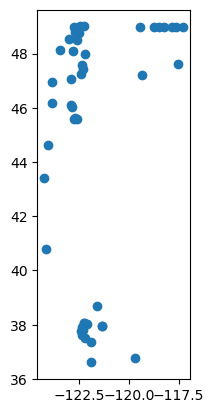

In [13]:
# write processed port flow
port_in_faf.plot()
port_in_faf.to_file('RawData/Port/port_location_with_faf_id.geojson',
                   driver="GeoJSON")

In [14]:
# select port and flow in study region, and generete attributes
port_in_faf['FAF'] = port_in_faf['FAF'].astype(int)
port_in_region = \
port_in_faf.loc[port_in_faf['FAF'].isin(region_code)]
port_in_region_df = port_in_region.drop(columns = 'geometry')

international_end_lookup = \
international_zonal_crosswalk[['Country', 'CFS_CODE', 'CFS_NAME']]

international_end_lookup = \
international_end_lookup.drop_duplicates(subset= 'Country')

print(international_end_lookup.CFS_NAME.unique())

# parsing import
regional_import_flow['Customs Value (Gen) ($US)'] = \
regional_import_flow['Customs Value (Gen) ($US)'].astype(float)

regional_import_flow.loc[:, 'HS Code'] = \
regional_import_flow.loc[:, 'Commodity'].str.split(' ').str[0]

regional_import_flow.loc[:, 'HS Code'] = \
regional_import_flow.loc[:, 'HS Code'].astype(int)

regional_import_flow = pd.merge(regional_import_flow,
                               international_end_lookup,
                               on = 'Country', how = 'left')

# parsing export
regional_export_flow['Total Exports Value ($US)'] = \
regional_export_flow['Total Exports Value ($US)'].astype(float)

regional_export_flow.loc[:, 'HS Code'] = \
regional_export_flow.loc[:, 'Commodity'].str.split(' ').str[0]

regional_export_flow.loc[:, 'HS Code'] = \
regional_export_flow.loc[:, 'HS Code'].astype(int)

regional_export_flow = pd.merge(regional_export_flow,
                               international_end_lookup,
                               on = 'Country', how = 'left')
regional_export_flow.head(5)

['Europe & Africa' 'Asia & Oceania' 'Canada' 'Mexico'
 'Rest of the Americas']


,Port,Commodity,Country,Time,Total Exports Value ($US),HS Code,CFS_CODE,CFS_NAME
0,"Columbia-Snake, OR (District)",01 Live Animals,Asia,2017,4833805.0,1,A,Asia & Oceania
1,"Columbia-Snake, OR (District)",01 Live Animals,Canada,2017,11146.0,1,C,Canada
2,"Columbia-Snake, OR (District)",02 Meat And Edible Meat Offal,Asia,2017,140508.0,2,A,Asia & Oceania
3,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Asia,2017,237953.0,3,A,Asia & Oceania
4,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Australia and Oceania,2017,85089.0,3,A,Asia & Oceania


In [16]:
# combine port location with flow
usato_import_in_region = pd.merge(port_in_region_df,
                                  regional_import_flow,
                                  left_on = 'CBP Port Location',
                                  right_on = 'Port',
                                  how = 'left')
print('total import in region:')
print(usato_import_in_region['Customs Value (Gen) ($US)'].sum()/10**6)
# usato_import_in_region.head(5)

usato_export_in_region = pd.merge(port_in_region_df,
                                  regional_export_flow,
                                  left_on = 'CBP Port Location',
                                  right_on = 'Port',
                                  how = 'left')
print('total export in region:')
print(usato_export_in_region['Total Exports Value ($US)'].sum()/10**6)
usato_export_in_region.head(5)

total import in region:
100758.050062
total export in region:
93865.988879


,NAME,STATE,PORTID,TYPE,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,...,index_right,FAF,Port,Commodity,Country,Time,Total Exports Value ($US),HS Code,CFS_CODE,CFS_NAME
0,portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,...,94,411,"Portland International Airport, OR (Port)",01 Live Animals,Canada,2017,11146.0,1,C,Canada
1,portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,...,94,411,"Portland International Airport, OR (Port)","03 Fish, Crustaceans & Aquatic Invertebrates",Asia,2017,237953.0,3,A,Asia & Oceania
2,portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,...,94,411,"Portland International Airport, OR (Port)","03 Fish, Crustaceans & Aquatic Invertebrates",Australia and Oceania,2017,85089.0,3,A,Asia & Oceania
3,portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,...,94,411,"Portland International Airport, OR (Port)","03 Fish, Crustaceans & Aquatic Invertebrates",Canada,2017,14781.0,3,C,Canada
4,portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,...,94,411,"Portland International Airport, OR (Port)","06 Live Trees, Plants, Bulbs Etc.; Cut Flowers...",Asia,2017,131970.0,6,A,Asia & Oceania


In [17]:
# writing intermediate outputs 
usato_import_in_region.to_csv('RawData/Port/Flow/cleaned_seattle_import.csv', index = False)
usato_export_in_region.to_csv('RawData/Port/Flow/cleaned_seattle_export.csv', index = False)

,dms_orig,value_usato,value_faf
0,411,6427.736939,13215.458828
1,531,72554.155285,48357.761857
2,532,2470.081534,218.275892
3,539,19306.076304,20307.563298


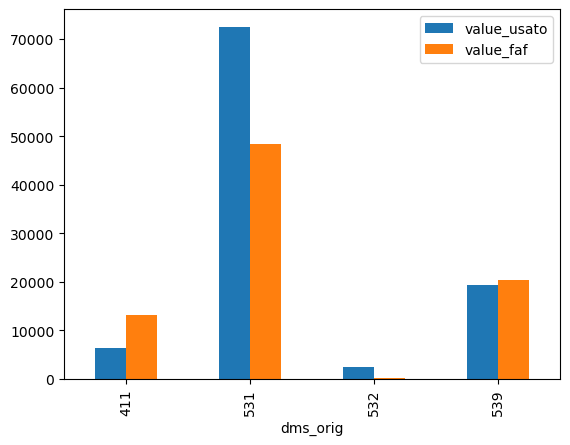

In [11]:
# Compare import (due to ~15% discrepancy)
usato_import_by_faf = \
usato_import_in_region.groupby('FAF')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_faf = usato_import_by_faf.reset_index()

usato_import_by_faf['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_faf.columns = ['dms_orig', 'value_usato']
faf_import_agg = \
regional_import.groupby('dms_orig')[['value_2017']].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['dms_orig', 'value_faf']
import_value_compare = pd.merge(usato_import_by_faf,
                               faf_import_agg, on = 'dms_orig',
                               how = 'left')

import_value_compare.plot(x = 'dms_orig', kind = 'bar')
import_value_compare

['Asia & Oceania' 'Canada' 'Europe & Africa' 'Mexico'
 'Rest of the Americas']


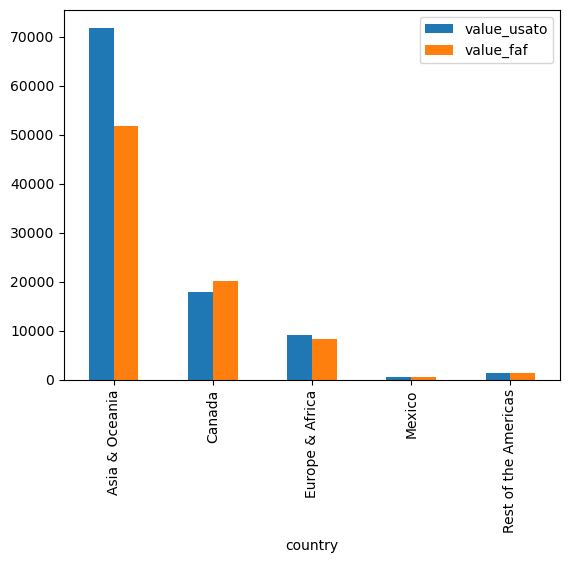

In [12]:
# Compare total import by country (due to ~15% discrepancy)
usato_import_by_country = \
usato_import_in_region.groupby('CFS_NAME')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_country = usato_import_by_country.reset_index()

usato_import_by_country['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_country.columns = ['country', 'value_usato']
faf_import_by_country = \
regional_import.groupby('CFS_NAME')[['value_2017']].sum()
faf_import_by_country = faf_import_by_country.reset_index()
faf_import_by_country.columns = ['country', 'value_faf']
import_value_compare = pd.merge(usato_import_by_country,
                               faf_import_by_country, 
                                on = 'country',
                               how = 'left')

import_value_compare.plot(x = 'country', kind = 'bar')
print(import_value_compare.country.unique())

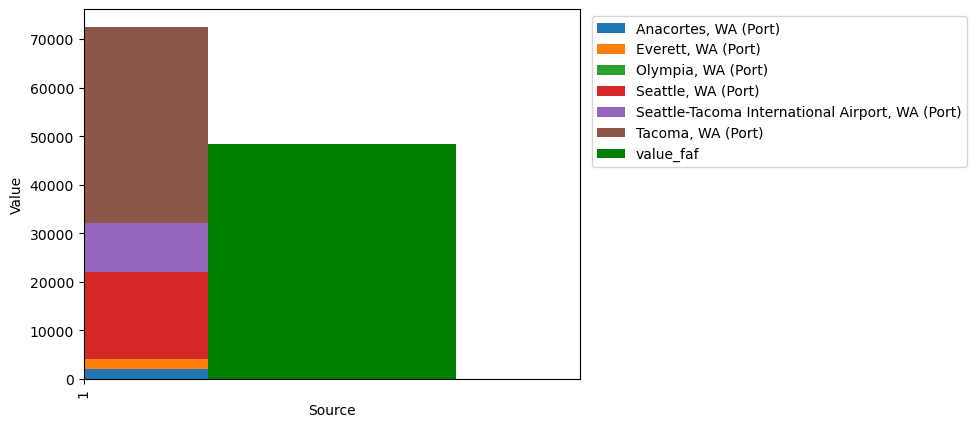

In [58]:
# look into Seattle a bit more
usato_import_sea = \
usato_import_in_region.loc[usato_import_in_region['FAF'] == 531]
usato_import_sea['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_sea = \
pd.pivot_table(usato_import_sea, columns = 'CBP Port Location', 
               values = 'Customs Value (Gen) ($US)', aggfunc = 'sum')


faf_import_sea = faf_import_agg.loc[faf_import_agg['dms_orig'] == 531]
# ax = faf_import_sea['value_faf'].plot.bar(ylabel="Value", xlabel="Source", figsize=(6,4), color='green', position=1)
ax = usato_import_sea.plot.bar(stacked=True)
faf_import_sea['value_faf'].plot.bar(ylabel="Value", xlabel="Source", 
                                     color='green',  position = -0.5,ax = ax)
plt.legend(fontsize = 10, bbox_to_anchor = (1.01, 1))

,dms_dest,value_usato,value_faf
0,411,6039.517306,6087.002969
1,531,59813.038137,60744.460330
2,532,7992.464280,7997.559760
3,539,20020.969156,21439.600142


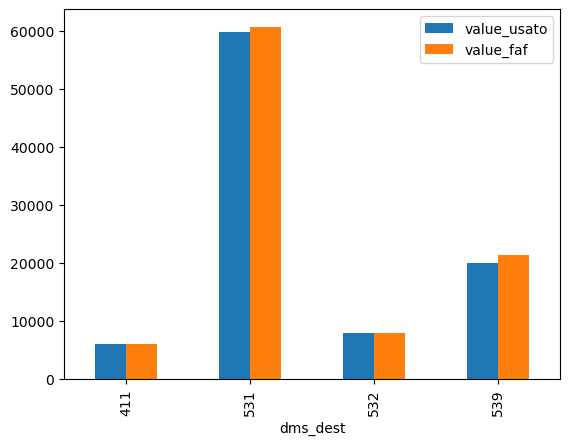

In [14]:
# compare export by faf zone

usato_export_by_faf = \
usato_export_in_region.groupby('FAF')[['Total Exports Value ($US)']].sum()
usato_export_by_faf = usato_export_by_faf.reset_index()

usato_export_by_faf['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_faf.columns = ['dms_dest', 'value_usato']
faf_export_agg = \
regional_export.groupby('dms_dest')[['value_2017']].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['dms_dest', 'value_faf']
export_value_compare = pd.merge(usato_export_by_faf,
                               faf_export_agg, on = 'dms_dest',
                               how = 'left')

export_value_compare.plot(x = 'dms_dest', kind = 'bar')
export_value_compare

,country,value_usato,value_faf
0,Asia & Oceania,56144.079404,38114.410938
1,Canada,16687.592445,50193.563408
2,Europe & Africa,17660.461736,5801.984166
3,Mexico,938.854927,563.100859
4,Rest of the Americas,2435.000367,1595.563830


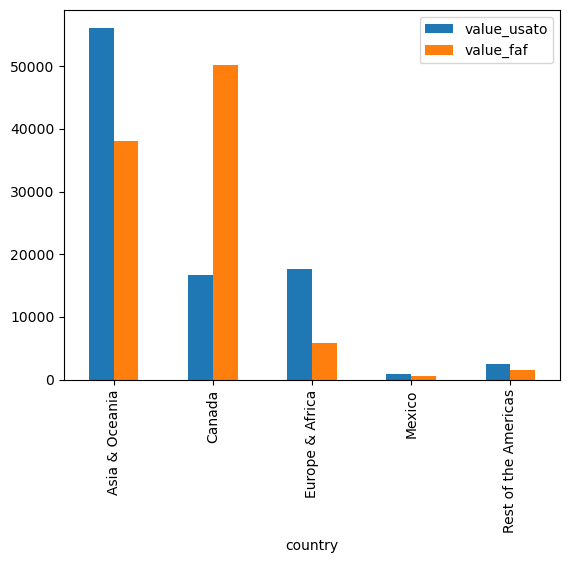

In [15]:
# compare export by foreign destination

usato_export_by_country = \
usato_export_in_region.groupby(['CFS_NAME'])[['Total Exports Value ($US)']].sum()
usato_export_by_country = usato_export_by_country.reset_index()

usato_export_by_country['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_country.columns = ['country', 'value_usato']
faf_export_by_country = \
regional_export.groupby(['CFS_NAME'])[['value_2017']].sum()
faf_export_by_country = faf_export_by_country.reset_index()
faf_export_by_country.columns = ['country', 'value_faf']
export_value_compare = pd.merge(usato_export_by_country,
                               faf_export_by_country, on = 'country',
                               how = 'left')

export_value_compare.plot(x = 'country', kind = 'bar')
export_value_compare

,FAF,country,value,source
0,411,Asia & Oceania,5220.934175,usato
1,411,Canada,17.386023,usato
2,411,Europe & Africa,195.859919,usato
3,411,Mexico,22.061162,usato
4,411,Rest of the Americas,471.522252,usato
5,531,Asia & Oceania,21194.482856,usato
6,531,Canada,1211.802777,usato
7,531,Europe & Africa,4744.712265,usato
8,531,Mexico,336.256632,usato
9,531,Rest of the Americas,612.947037,usato


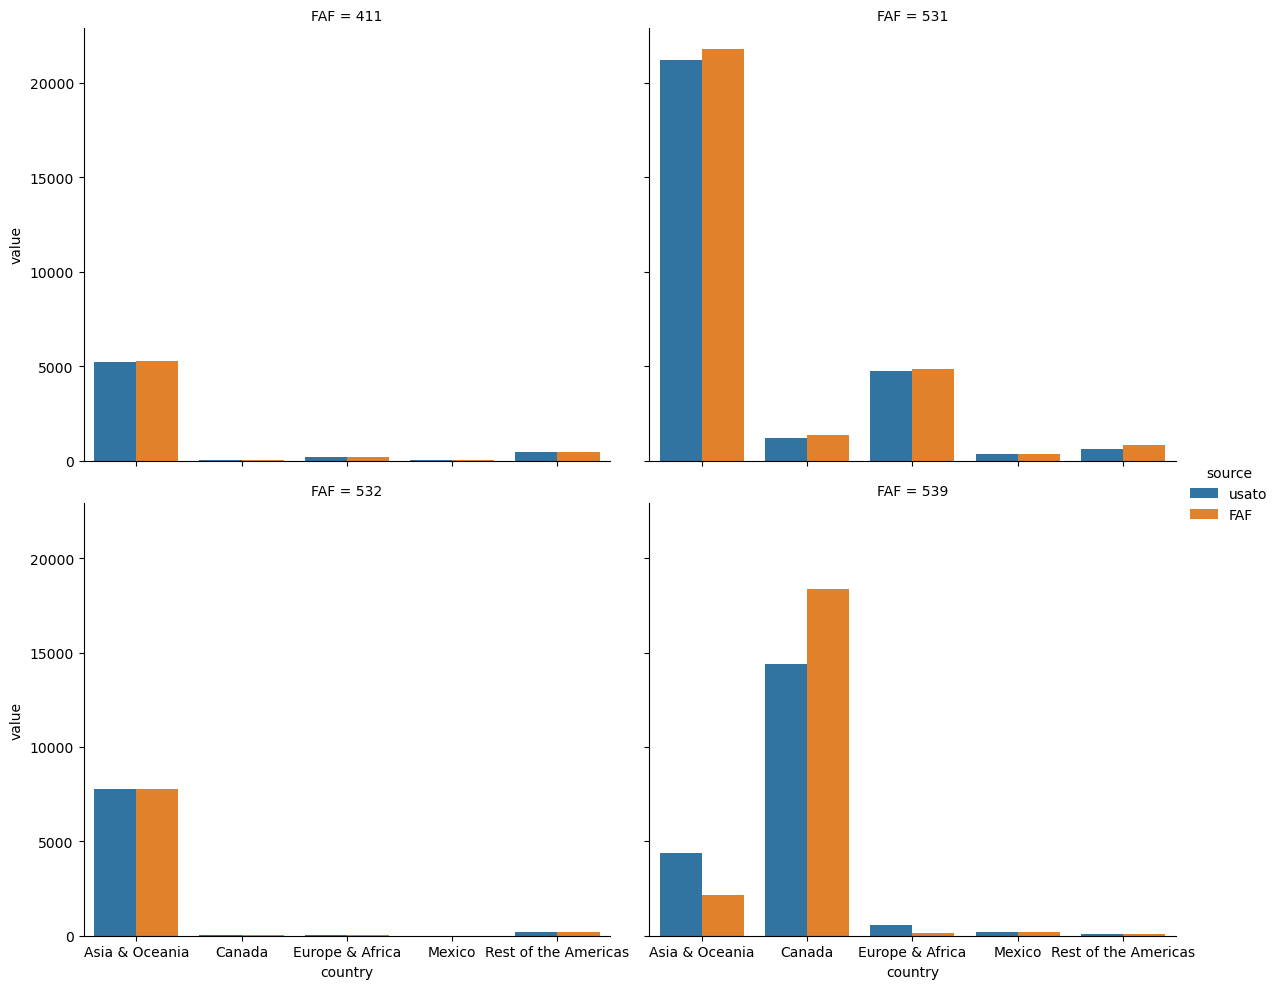

In [25]:
# compare export by foreign destination
# drop aircraft
usato_export_in_region = \
usato_export_in_region.loc[usato_export_in_region['HS Code'] != 88]
regional_export = regional_export.loc[regional_export['sctg2'] != 37]

usato_export_by_country = \
usato_export_in_region.groupby(['FAF', 'CFS_NAME'])[['Total Exports Value ($US)']].sum()
usato_export_by_country = usato_export_by_country.reset_index()

usato_export_by_country['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_country.columns = ['FAF', 'country', 'value']
usato_export_by_country.loc[:, 'source'] = 'usato'
faf_export_by_country = \
regional_export.groupby(['dms_dest', 'CFS_NAME'])[['value_2017']].sum()
faf_export_by_country = faf_export_by_country.reset_index()
faf_export_by_country.columns = ['FAF', 'country', 'value']
faf_export_by_country.loc[:, 'source'] = 'FAF'
export_value_compare = pd.concat([usato_export_by_country,
                               faf_export_by_country])

sns.catplot(data = export_value_compare,
            x = 'country', y = 'value', hue = 'source', col = 'FAF',
            col_wrap = 2, aspect = 1.2, height = 5,
            kind = 'bar')
export_value_compare

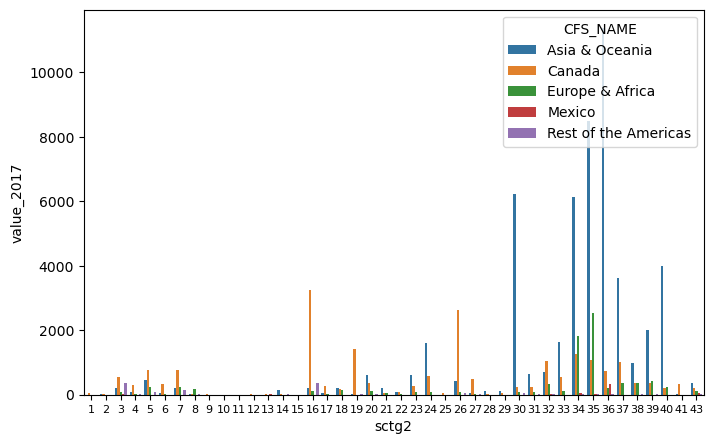

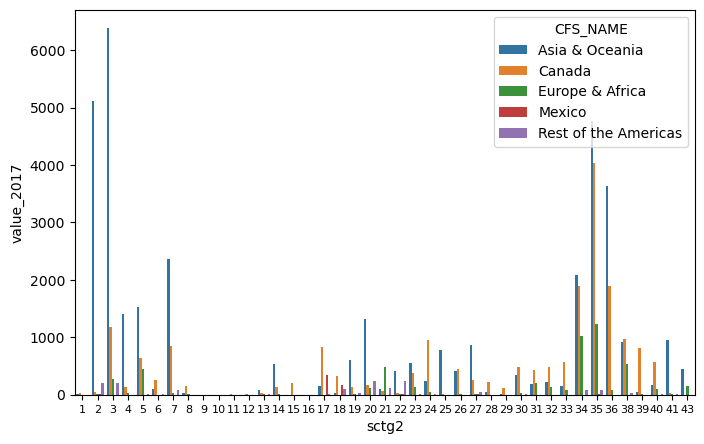

In [26]:
# check by sctg distribution by country
faf_import_by_sctg = \
regional_import.groupby(['CFS_NAME', 'sctg2'])[['value_2017']].sum()
faf_import_by_sctg = faf_import_by_sctg.reset_index()

plt.figure(figsize = (8,5))
sns.barplot(faf_import_by_sctg, x= 'sctg2', y = 'value_2017', 
            hue = 'CFS_NAME')
plt.xticks(fontsize = 8)
plt.show()

faf_export_by_sctg = \
regional_export.groupby(['CFS_NAME', 'sctg2'])[['value_2017']].sum()
faf_export_by_sctg = faf_export_by_sctg.reset_index()

plt.figure(figsize = (8,5))
sns.barplot(faf_export_by_sctg, x= 'sctg2', y = 'value_2017', 
            hue = 'CFS_NAME')
plt.xticks(fontsize = 8)
plt.show()